In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import transformer
from Regular_transfer_NN import NN 
from Regular_transfer_NN import RegularTransferNN
from Regular_transfer_NN import Combined_NN

<h2>Create Sample Data</h2>

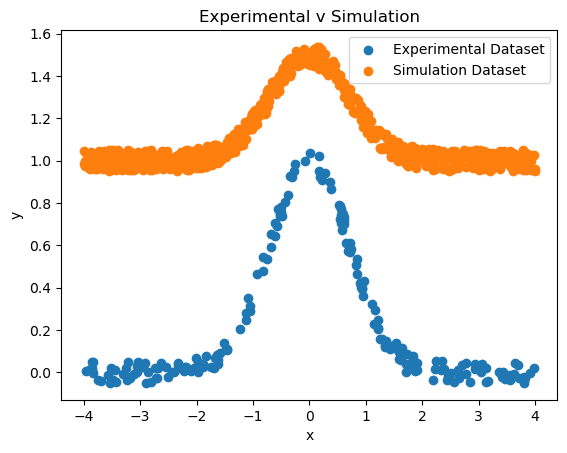

In [2]:
bound = 4

#function to produde results based on x values
def create_gaussian_curve(x, a, shift_up, shift_amp):
    #C + Aexp((-x-a)^2)
    y = shift_up + shift_amp*np.exp(-(x-a)**2) + np.random.uniform(-0.05, 0.05, size=x.shape)
    return y

# Generate 100 random points
np.random.seed(0)  # For reproducibility
exp_x_points = np.random.uniform(-bound, bound, bound*50)
sim_x_points = np.random.uniform(-bound, bound, bound*200)

#Compute results
exp_y_points = create_gaussian_curve(exp_x_points,0, 0, 1)
sim_y_points = create_gaussian_curve(sim_x_points,0, 1, 0.5)

fig, ax = plt.subplots()


ax.scatter(exp_x_points, exp_y_points, label='Experimental Dataset')
ax.scatter(sim_x_points, sim_y_points, label='Simulation Dataset')

plt.title("Experimental v Simulation")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

<h2>Normalization</h2>

In [3]:
#function to split on a pivot oppsed to a percentage
def split_on_point(x_values, y_values, pivot):
    #initialize arrays
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    #for each x, if it is above the pivot, add the x and it's correlating y value
    for i, x in enumerate(x_values):
        if x > pivot:
            x_train.append(x)
            y_train.append(y_values[i])
        else:
            x_test.append(x)
            y_test.append(y_values[i])
            
    #convert all training gand testing arrays to tensors
    x_train = torch.tensor(x_train, dtype=torch.float32).reshape(-1,1)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1,1)
    x_test = torch.tensor(x_test, dtype=torch.float32).reshape(-1,1)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1,1)
    return x_train, y_train, x_test, y_test

In [4]:
#Setting Bounds
x_bounds = torch.tensor([-bound, bound])
y_bounds = torch.tensor([0, 2])

#define transformers
x_transformer = transformer.Transformer(x_bounds.reshape(2,1), transform_type = 'normalize')
y_transformer = transformer.Transformer(y_bounds.reshape(2,1), transform_type = 'normalize')

#Full normalization process
def normalization(array, transformer):
    array = np.array(array).reshape(-1,1)
    array = torch.tensor(array)
    norm = transformer.forward(array)
    norm = torch.tensor(norm, dtype=torch.float32).reshape(-1,1)
    return norm

In [5]:
#normalize
sim_x_points = normalization(sim_x_points, x_transformer)
sim_y_points = normalization(sim_y_points, y_transformer)
exp_x_points = normalization(exp_x_points, x_transformer) 
exp_y_points = normalization(exp_y_points, y_transformer)

/tmp/ipykernel_1996333/1552577584.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm = torch.tensor(norm, dtype=torch.float32).reshape(-1,1)


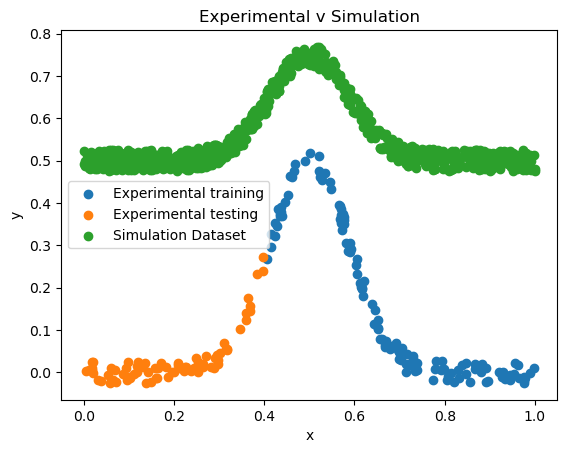

In [6]:
exp_x_train, exp_y_train, exp_x_test, exp_y_test = split_on_point(exp_x_points, exp_y_points, 0.4)

fig, ax = plt.subplots()

ax.scatter(exp_x_train, exp_y_train, label='Experimental training')
ax.scatter(exp_x_test, exp_y_test, label='Experimental testing')
ax.scatter(sim_x_points, sim_y_points, label='Simulation Dataset')

plt.title("Experimental v Simulation")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

<h2>Neural Network</h2>

In [7]:
sim_net = NN()
sim_net.train_model(sim_x_points, sim_y_points)
sim_predictions = sim_net.predict(exp_x_points)

sim NN: Epoch [150/1500], Loss:0.006808
sim NN: Epoch [300/1500], Loss:0.005630
sim NN: Epoch [450/1500], Loss:0.002022
sim NN: Epoch [600/1500], Loss:0.001118
sim NN: Epoch [750/1500], Loss:0.000522
sim NN: Epoch [900/1500], Loss:0.000235
sim NN: Epoch [1050/1500], Loss:0.000225
sim NN: Epoch [1200/1500], Loss:0.000222
sim NN: Epoch [1350/1500], Loss:0.000220
sim NN: Epoch [1500/1500], Loss:0.000219


In [8]:
#simple exp net
simple_exp_net = NN()
simple_exp_net.train_model(exp_x_train, exp_y_train, num_epochs=10000)
simple_exp_predictions = simple_exp_net.predict(exp_x_points)

sim NN: Epoch [1000/10000], Loss:0.000204
sim NN: Epoch [2000/10000], Loss:0.000201
sim NN: Epoch [3000/10000], Loss:0.000198
sim NN: Epoch [4000/10000], Loss:0.000194
sim NN: Epoch [5000/10000], Loss:0.000192
sim NN: Epoch [6000/10000], Loss:0.000186
sim NN: Epoch [7000/10000], Loss:0.000184
sim NN: Epoch [8000/10000], Loss:0.000181
sim NN: Epoch [9000/10000], Loss:0.000181
sim NN: Epoch [10000/10000], Loss:0.000179


In [9]:
comb_exp_net = Combined_NN(sim_net)
comb_exp_net.train_model(exp_x_train, exp_y_train)
comb_exp_net_pred = comb_exp_net.predict(exp_x_points)

Comb NN: Epoch [1000/10000], Loss:0.048382
Comb NN: Epoch [2000/10000], Loss:0.048375
Comb NN: Epoch [3000/10000], Loss:0.048375
Comb NN: Epoch [4000/10000], Loss:0.048375
Comb NN: Epoch [5000/10000], Loss:0.048375
Comb NN: Epoch [6000/10000], Loss:0.048375
Comb NN: Epoch [7000/10000], Loss:0.048375
Comb NN: Epoch [8000/10000], Loss:0.048375
Comb NN: Epoch [9000/10000], Loss:0.048375
Comb NN: Epoch [10000/10000], Loss:0.048375


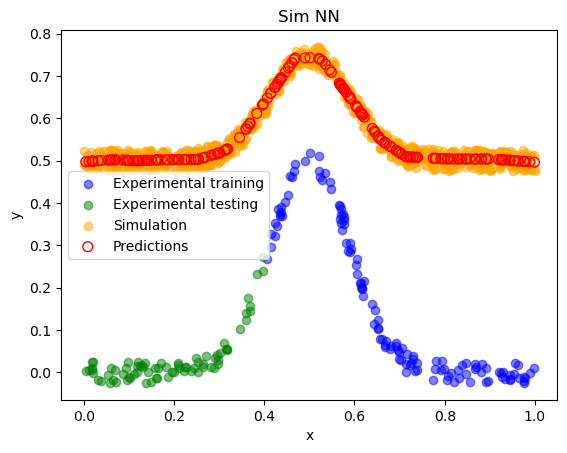

In [10]:
plt.scatter(exp_x_train, exp_y_train, label='Experimental training', color='blue', alpha=0.5)
plt.scatter(exp_x_test, exp_y_test, label='Experimental testing', color='green', alpha=0.5)
plt.scatter(sim_x_points, sim_y_points, label='Simulation', color='orange', alpha=0.5)
plt.scatter(exp_x_points, sim_predictions, label='Predictions', s=50, facecolors='none', edgecolors='r')
plt.title('Sim NN')  
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

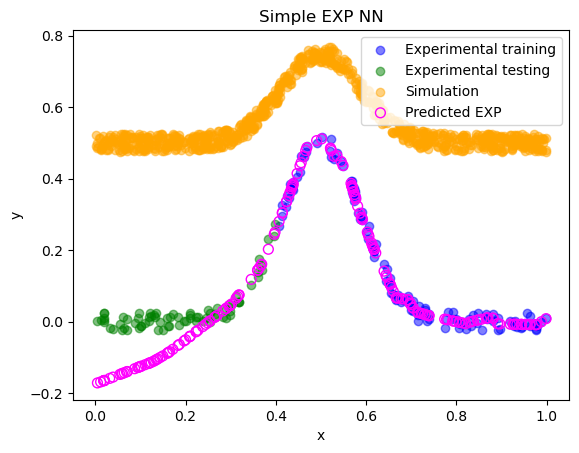

In [11]:
plt.scatter(exp_x_train, exp_y_train, label='Experimental training', color='blue', alpha=0.5)
plt.scatter(exp_x_test, exp_y_test, label='Experimental testing', color='green', alpha=0.5)
plt.scatter(sim_x_points, sim_y_points, label='Simulation', color='orange', alpha=0.5)

plt.scatter(exp_x_points, simple_exp_predictions, label='Predicted EXP', facecolors='none', edgecolors='magenta', s=50)

plt.title('Simple EXP NN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper right')
plt.show()

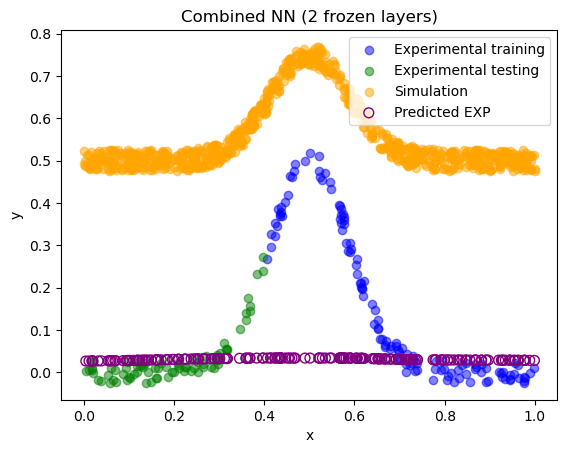

In [12]:
plt.scatter(exp_x_train, exp_y_train, label='Experimental training', color='blue', alpha=0.5)
plt.scatter(exp_x_test, exp_y_test, label='Experimental testing', color='green', alpha=0.5)
plt.scatter(sim_x_points, sim_y_points, label='Simulation', color='orange', alpha=0.5)

#plt.scatter(exp_x_points, sim_predictions, label='Predicted SIM', facecolors='none', edgecolors='r', s=50)
#plt.scatter(exp_x_points, simple_exp_predictions, label='Predicted EXP', facecolors='none', edgecolors='yellow', s=50)
plt.scatter(exp_x_points, comb_exp_net_pred, label='Predicted EXP', facecolors='none', edgecolors='purple', s=50)

plt.title('Combined NN (2 frozen layers)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper right')
plt.show()